In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
#import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from epi.models import Parameter, Model
from epi.normalizing_flows import NormalizingFlow
from epi.util import pairplot, AugLagHPs

from epi.example_eps import load_W
import tensorflow as tf

neuron_inds = {'E':0, 'P':1}
figdir = "./"

In [2]:
sigma_eps = 0.0

black = np.array([0, 0, 0])
blue = '#4769A0'
red = '#AF3A31'
green = '#287C5A'
colors = [black, blue, red, green]

In [3]:
# Dim is [M,N,|r|,T]
def euler_sim_stoch(f, x_init, dt, T):
    x = x_init
    for t in range(T):
        x = x + f(x) * dt
    return x[:, :, :, 0]

def euler_sim_stoch_traj(f, x_init, dt, T):
    x = x_init
    xs = [x_init]
    for t in range(T):
        x = x + f(x) * dt
        xs.append(x)
    return tf.concat(xs, axis=3)

## 4-neuron model

In [4]:
neuron_inds = {'E':0, 'P':1, 'S':2, 'V':3}
V_INIT = tf.constant(-65.*np.ones((1,4,1)), dtype=np.float32)


k = 0.3
n = 2.
v_rest = -70.

dt = 0.005

N = 5
T = 100

def f_r(v):
    return k*(tf.nn.relu(v-v_rest)**n)

# Dim is [M,N,|r|,T]
def SSSN_sim_traj(h):
    h = h[:,None,:,None]

    W = load_W()
    sigma_eps = 0.2*np.array([1., 0.5, 0.5, 0.5])
    tau = np.array([0.02, 0.01, 0.01, 0.01])
    tau_noise = np.array([0.05, 0.05, 0.05, 0.05])

    W = W[None,:,:,:]
    sigma_eps = sigma_eps[None,None,:,None]
    tau = tau[None,None,:,None]
    tau_noise = tau_noise[None,None,:,None]
   
    _v_shape = tf.ones((h.shape[0], N, 4, 1), dtype=tf.float32)
    v_init = _v_shape*V_INIT
    eps_init = 0.*_v_shape
    y_init = tf.concat((v_init, eps_init), axis=2)
    
    def f(y):
        v = y[:,:,:4,:]
        eps = y[:,:,4:,:]
        B = tf.random.normal(eps.shape, 0., np.sqrt(dt))
       
        dv = (-v + v_rest + h + eps + tf.matmul(W, f_r(v))) / tau
        deps = (-eps + (np.sqrt(2.*tau_noise)*sigma_eps*B/dt)) / tau_noise
        
        return tf.concat((dv, deps), axis=2)
        
    v_t = euler_sim_stoch_traj(f, y_init, dt, T)
    
    return v_t

def SSSN_sim(h):
    h = h[:,None,:,None]

    W = load_W()
    sigma_eps = .2*np.array([1., 0.5, 0.5, 0.5])
    tau = np.array([0.02, 0.01, 0.01, 0.01])
    tau_noise = np.array([0.05, 0.05, 0.05, 0.05])

    W = W[None,:,:,:]
    sigma_eps = sigma_eps[None,None,:,None]
    tau = tau[None,None,:,None]
    tau_noise = tau_noise[None,None,:,None]
   
    _v_shape = tf.ones((h.shape[0], N, 4, 1), dtype=tf.float32)
    v_init = _v_shape*V_INIT
    eps_init = 0.*_v_shape
    y_init = tf.concat((v_init, eps_init), axis=2)
    
    def f(y):
        v = y[:,:,:4,:]
        eps = y[:,:,4:,:]
        B = tf.random.normal(eps.shape, 0., np.sqrt(dt))
       
        dv = (-v + v_rest + h + eps + tf.matmul(W, f_r(v))) / tau
        deps = (-eps + (np.sqrt(2.*tau_noise)*sigma_eps*B/dt)) / tau_noise
        
        return tf.concat((dv, deps), axis=2)
        
    v_ss = euler_sim_stoch(f, y_init, dt, T)
    return v_ss

#def SSSN_stats(h):
#    v_t = SSSN_sim_traj(h)[:,:,:4,:]
#    r_t = v_t
#    avg_r = tf.reduce_mean(r_t[:,:,:,(T//2):], axis=3)
#   std_r = tf.math.reduce_std(r_t[:,:,:,(T//2):], axis=3)
#    
#    mean_avg_r = tf.reduce_mean(avg_r, axis=1)
#    mean_std_r = tf.reduce_mean(std_r, axis=1)
#   std_std_r = tf.math.reduce_std(std_r, axis=1)
#    
#    return tf.concat((mean_avg_r, mean_std_r, std_std_r), axis=1)

In [5]:
lb_h = 0.*np.ones((4,))
ub_h = 25.*np.array([1., 1., 1., 1.])

lb_dh = -10.
ub_dh = 10.

h = Parameter("h", 4, lb=lb_h, ub=ub_h)
dh = Parameter("dh", 1, lb=lb_dh, ub=ub_dh)
parameters = [h, dh]

diff_prod_mean = -.25
diff_sum_mean = 0.
def SV_flip(h, dh):
    dh_pattern = tf.constant(np.array([[1., 1., 0., 0.]], dtype=np.float32))
    dh = dh*dh_pattern
   
    ss1 = tf.reduce_mean(f_r(SSSN_sim(h)[:,:,:4]), axis=1)
    ss2 = tf.reduce_mean(f_r(SSSN_sim(h+dh)[:,:,:4]), axis=1)
    
    diff1 = (ss1[:,2]-ss1[:,3]) / tf.norm(ss1, axis=1, keepdims=False)
    diff2 = (ss2[:,2]-ss2[:,3]) / tf.norm(ss2, axis=1, keepdims=False)
    diff_prod = diff1*diff2
    diff_sum = diff1+diff2
    T_x = tf.stack((diff_prod, 
                    diff_sum, 
                    (diff_prod - diff_prod_mean) ** 2, 
                    (diff_sum-diff_sum_mean) ** 2), axis=1)

    return T_x

In [6]:
# Define model
name = "V1Circuit"
model = Model(name, parameters)
model.set_eps(SV_flip)

In [8]:
D = sum([param.D for param in model.parameters])
lb = np.concatenate([param.lb for param in model.parameters])
ub = np.concatenate([param.ub for param in model.parameters])

M = 1000
num_keep = 1000

mean = [diff_prod_mean]
std = [np.abs(diff_prod_mean)/2.]
def accept_inds(T_x, mean ,std):
    return np.logical_and(mean[0]-2*std[0] < T_x[:,0], T_x[:,0] < mean[0]+2*std[0])
    #return np.logical_and(np.logical_and(mean[0]-2*std[0] < T_x[:,0], T_x[:,0] < mean[0]+2*std[0]),
    #                      np.logical_and(mean[1]-2*std[1] < T_x[:,1], T_x[:,1] < mean[1]+2*std[1]))

num_found = 0
z = None
T_x = None
x = []
while (num_found < num_keep):
    _z = np.zeros((M, D))
    for j in range(D):
        _z[:,j] = np.random.uniform(lb[j], ub[j], (M,))
    _T_x = model.eps(_z).numpy()

    inds = accept_inds(_T_x, mean, std)
    _z = _z[inds, :]
    _T_x = _T_x[inds, :]
    num_found += _z.shape[0]

    if (z is None):
        z = _z
        T_x = _T_x
    else:
        z = np.concatenate((z, _z), axis=0)
        T_x = np.concatenate((T_x, _T_x), axis=0)
    print('%d/%d\r' % (num_found, num_keep), end='')
    x.append(num_found)

num_found = z.shape[0]

# reduce to num_keep
z = z[:num_keep]
T_x = T_x[:num_keep]

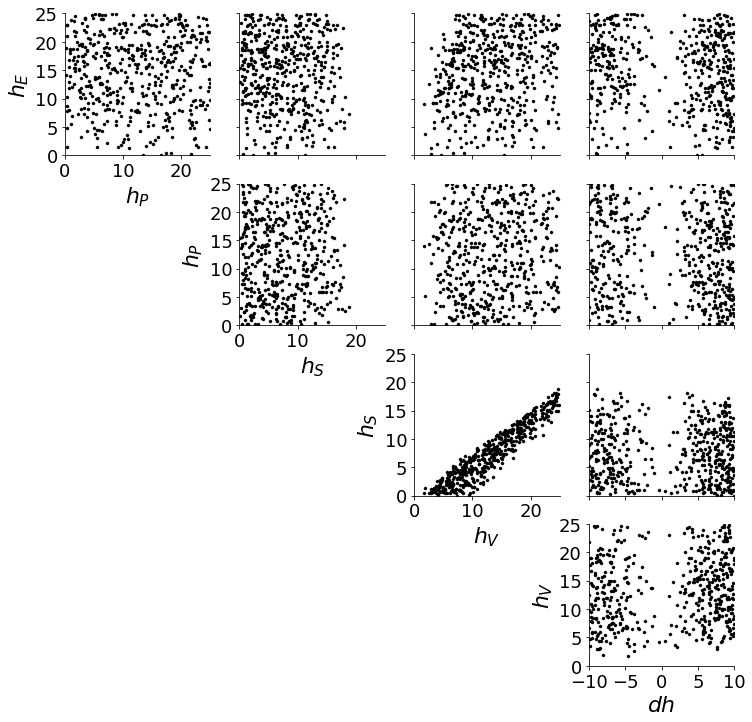

In [10]:
num_plot = 500
fontsize = 14
z_labels = [r'$h_E$', r'$h_P$', r'$h_S$', r'$h_V$', r'$dh$']
fig = pairplot(z[:num_plot], np.arange(5), z_labels,
               fontsize=22,
               lb=lb, ub=ub)
plt.savefig(figdir + 'SV_flip_ABC_z.png')
               #c_label='prod')

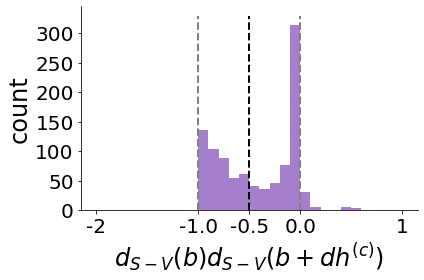

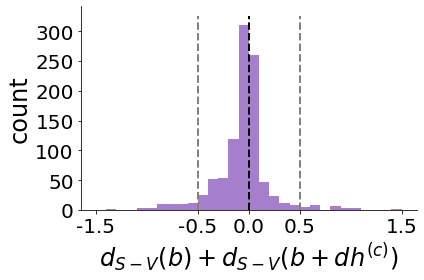

In [11]:
from epi.util import plot_T_x

# select by mu
if diff_prod_mean == -0.25:
    mu = np.array([-0.25, 0.0, 0.125**2, 0.125**2])
elif diff_prod_mean == -0.4:
    mu = np.array([-0.4, 0.0, 0.2**2, 0.2**2])
elif diff_prod_mean == -0.5:
    mu = np.array([-0.5, 0.0, 0.25**2, 0.25**2])
    
    
T_x = model.eps(z).numpy()
xmins = [-2, -1.5]
xmaxs = [1, 1.5]
xlabels = [r"$d_{S-V}(b)d_{S-V}(b+dh^{(c)})$",
           r"$d_{S-V}(b) + d_{S-V}(b+dh^{(c)})$"]
for i in range(2):
    plot_T_x(None, T_x[:,i], xmin=xmins[i], xmax=xmaxs[i], 
             x_mean = mu[i], x_std = np.sqrt(mu[i+2]),
             xlabel=xlabels[i], fontsize=24)
    plt.tight_layout()
    plt.savefig(figdir + 'SVflip_Tx%d.png' % (i+1))

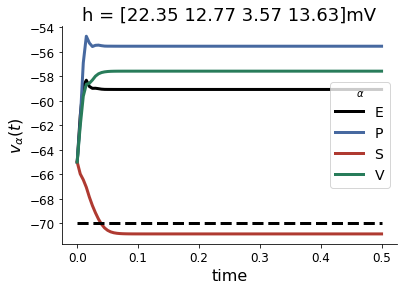

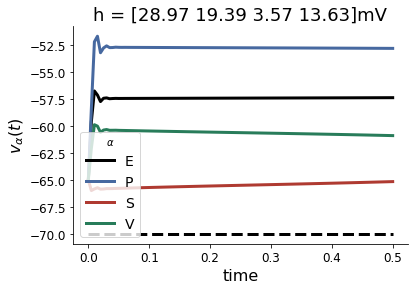

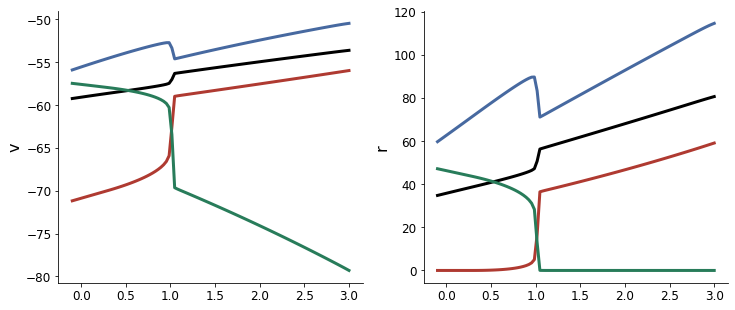

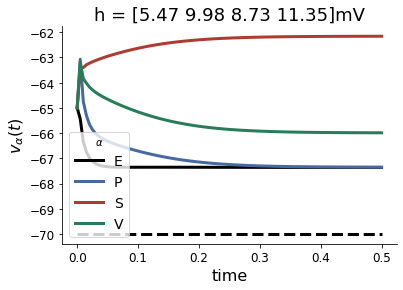

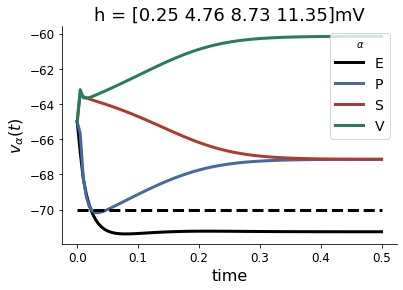

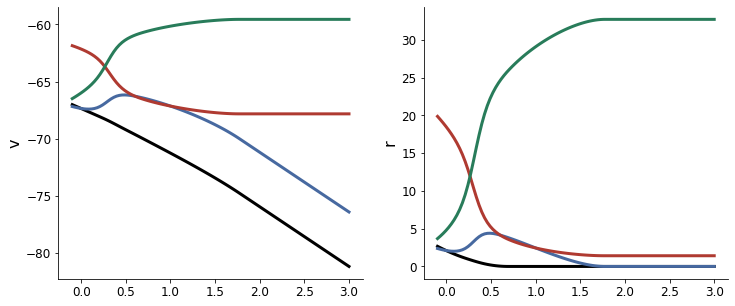

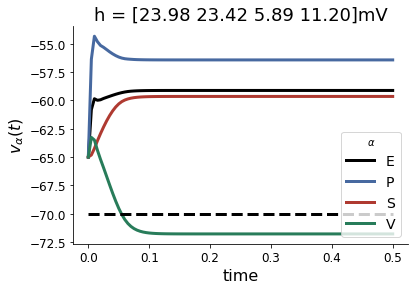

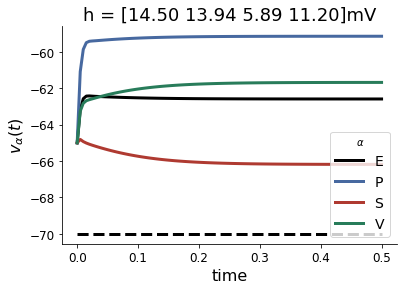

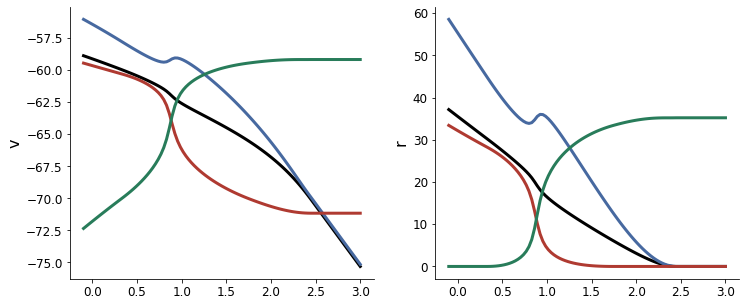

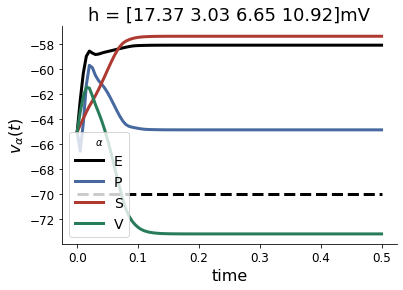

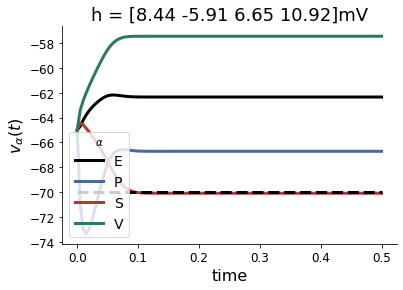

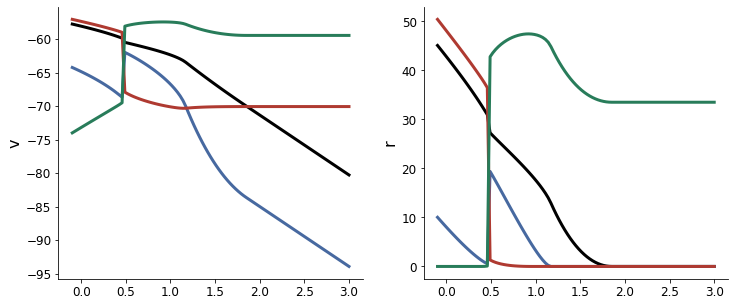

In [25]:
def plot_responses(z):
    h = z[:4]
    dh = z[4]
    gamma = np.concatenate((np.array([0., 1.]), np.linspace(-.1, 3., 101)), axis=0)
    dh_pattern = tf.constant(np.array([[1., 1., 0., 0.]], dtype=np.float32))
    _h = h + dh*gamma[:,None]*dh_pattern
    v_t = SSSN_sim_traj(_h).numpy()
    #T_x = SSN_stats(_h)
    
    neurons = ['E', 'P', 'S', 'V']
    """plt.figure()
    for i in range(4):
        plt.errorbar(gamma[2:], T_x[2:,i], T_x[2:,i+4], c=colors[i])
    plt.legend(neurons)
    plt.ylabel('means')
    plt.show()
    
    plt.figure()
    for i in range(4):
        plt.errorbar(gamma[2:], T_x[2:,i+4], T_x[2:,i+8], c=colors[i])
    plt.ylabel('noise')
    plt.legend(neurons)
    plt.show()"""


    
    t = dt*np.arange(T+1)
    
    for gamma_ind in [0, 1]:
        plt.figure()
        for neuron in neurons:
            ind = neuron_inds[neuron]
            plt.plot(t, v_t[gamma_ind,0,ind,:], c=colors[ind], lw=3)
        plt.plot([t[0], t[-1]], [-70, -70], 'k--', lw=3)
        h_gamma = _h[gamma_ind]
        plt.title('h = [%.2f %.2f %.2f %.2f]mV' % tuple([h_gamma[j] for j in range(4)]))
        plt.xlabel('time')
        plt.ylabel(r'$v_\alpha(t)$')
        plt.legend(neurons, title=r'$\alpha$')
        plt.show()
    
        
    fig, axs = plt.subplots(1,2,figsize=(12,5))
    for neuron in neurons:
        ind = neuron_inds[neuron]
        axs[0].plot(gamma[2:], v_t[2:,0,ind,-1], c=colors[ind], lw=3)
        axs[1].plot(gamma[2:], f_r(v_t[2:,0,ind,-1]), c=colors[ind], lw=3)
    axs[0].set_ylabel('v')
    axs[1].set_ylabel('r')
    plt.show()
    return None

for i in range(4):
    plot_responses(z[i])
